# GAN generation with StyleGAN for the Northern Grounds studio workshop

Run all cells down to "generate samples" and go from there. Mount Google Drive under the files bar the left if you want to save your results there, and set the correct path below.

Seeds are seeds for the random generator.

Interpolation is going from one coordinate in the latent space of the model to another.

Truncation (psi) is the "weirdness" factor.

0.0 = no variation.
<br>0.7-1.0 = variation, not so weird
<br>&gt;1.5 = possibly very weird

# Install StyleGAN2-ADA

In [60]:
%tensorflow_version 1.x
!git clone https://github.com/eswahn/stylegan2-ada
%cd stylegan2-ada

import os
import tensorflow as tf
import PIL.Image
import numpy as np
import glob
import math
import re
import random
import pickle
import dnnlib
import dnnlib.tflib as tflib

!nvidia-smi -L

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 380 (delta 21), reused 9 (delta 5), pack-reused 340
Receiving objects: 100% (380/380), 56.20 MiB | 7.72 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/stylegan2-ada/stylegan2-ada
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c07c52cf-b829-b702-3b43-897faea9db29)


# Select a pre-trained model and output path

In [86]:
model = 'Northern Grounds isometric' #@param ['Northern Grounds isometric', 'Northern Grounds plan', 'Wikiart', 'FFHQ'] {type:"string"}
output_path = '/content/drive/MyDrive/Output/' #@param {type:'string'}

#@markdown Or specify a path to a pkl model file:

pkl_path = '' #@param {type:'string'}

# Load model

In [87]:
# Load the most recent .pkl file from this directory:
 
resolution = 512

# Or specify the path or URL to a particular .pkl file:

if pkl_path == '':
  pkl_path = '/content/network.pkl'

  if model == 'Northern Grounds isometric':
    !gdown --id 1Q50DV-9vt26Yo9SuJJrkok_9W0gtd4Vt -O /content/network.pkl

  if model == 'Northern Grounds plan':
    !gdown --id 13bqHWHEIm2Dd-05Ck1086z0rpnF39uot -O /content/network.pkl

  if model == 'Wikiart':
    !gdown --id 1_GYAYJJLK_LebYZaEiSfHUWeU67VWeal -O /content/network.pkl 

  if model == 'FFHQ':
    !gdown --id 1R7gULo1oZgdwhIhkrzMgLQ4uBsM73qZj -O /content/network.pkl

if pkl_path:
  network_pkl = pkl_path
else:
  allpickles = glob.glob(os.path.join(network_dir, '*', 'network-*.pkl'))
  allpickles.sort(key=os.path.getctime)
  network_pkl = allpickles[-1]
 
print("Loading ", network_pkl)
 
def load_networks(path_or_url):
    if dnnlib.util.is_url(path_or_url):
        stream = dnnlib.util.open_url(path_or_url, cache_dir='.stylegan2-cache')
    else:
        stream = open(path_or_url, 'rb')
    tflib.init_tf()
    with stream:
        G, D, Gs = pickle.load(stream, encoding='latin1')
    return G, D, Gs

_G, _D, Gs = load_networks(network_pkl)
 
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
rnd = np.random.RandomState(0)
n = {var: rnd.randn(*var.shape.as_list()) for var in noise_vars}
tflib.set_vars(n)
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

Downloading...
From: https://drive.google.com/uc?id=1Q50DV-9vt26Yo9SuJJrkok_9W0gtd4Vt
To: /content/network.pkl
364MB [00:02, 136MB/s]
Loading  /content/network.pkl


# Define functions

In [88]:
if not os.path.exists(output_path):
  os.makedirs(output_path)
 
def set_truncation(n):
  Gs_kwargs.truncation_psi =  n # It can be disabled by setting truncation_psi=1

def truncation():
  return Gs_kwargs.truncation_psi

def get_seed(seed):
  rnd1 = np.random.RandomState(seed)
  z1 = rnd1.randn(1, *Gs.input_shape[1:])
  n1 = {var: rnd1.randn(*var.shape.as_list()) for var in noise_vars}
  return z1, n1
 
def mix_latents(latents1, latents2, ratio):
  z1, n1 = latents1
  z2, n2 = latents2
  ni = {var: (n1[var]*(1-ratio) + n2[var]*ratio) for var in n1}
  zi = z1*(1-ratio) + z2*ratio
  return zi, ni
 
def mix_seeds(seed1, seed2, ratio):
  rnd1 = np.random.RandomState(seed1)
  rnd2 = np.random.RandomState(seed2)
  z1 = rnd1.randn(1, *Gs.input_shape[1:])
  z2 = rnd2.randn(1, *Gs.input_shape[1:])
  n1 = {var: rnd1.randn(*var.shape.as_list()) for var in noise_vars}
  n2 = {var: rnd2.randn(*var.shape.as_list()) for var in noise_vars}
  ni = {var: (n1[var]*(1-ratio) + n2[var]*ratio) for var in n1}
  zi = z1*(1-ratio) + z2*ratio
  return zi, ni
 
def save_images(seeds, images_path):
  psi = Gs_kwargs.truncation_psi
  for seed in seeds:
    img = generate(*get_seed(seed))
    img.save(os.path.join(images_path, 'image_seed%05d_psi%.2f.png' % (seed, psi)))
 
def generate(z,n):
  tflib.set_vars(n)
  images = Gs.run(z, None, **Gs_kwargs)
  if images[0].shape[2] == 4:
    img = PIL.Image.fromarray(images[0], 'RGBA')
    r, g, b, _ = img.split()
    img = PIL.Image.merge("RGB", (r, g, b))
  elif images[0].shape[2] == 1:
    L = PIL.Image.fromarray(np.squeeze(images[0], axis=(2,)), 'L')
    img = PIL.Image.merge("RGB", (L, L, L))
  else:
    img = PIL.Image.fromarray(images[0], 'RGB')
  return img
 
set_truncation(1.0)

# Generate samples

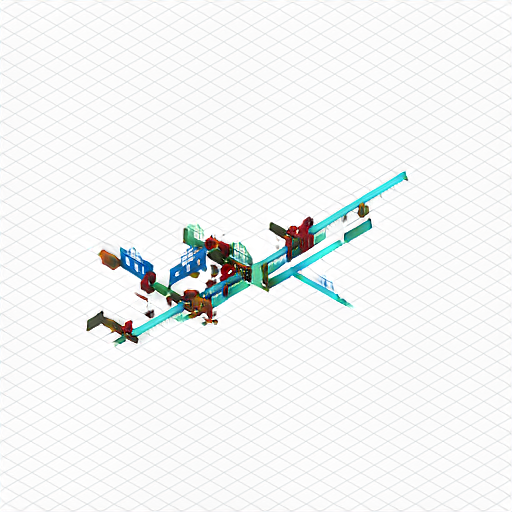

In [89]:
# Generate one image

set_truncation(0.7)
seed = 1

generate(*get_seed(seed))

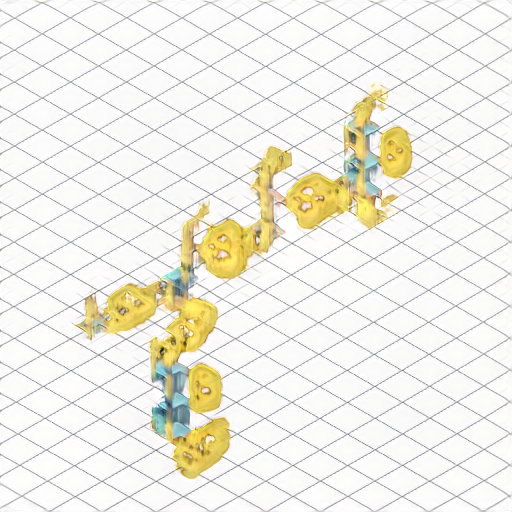

In [90]:
# Generate a mix between two seeds

set_truncation(1.0)
seed_a = 23478
seed_b = 1
ratio = 0.8

generate(*mix_seeds(seed_a, seed_b, ratio))

In [82]:
# Generate and save a number of images to folder

set_truncation(0.7)
seed_start = 0
seed_end = 20

seeds = range(seed_start, seed_end) 
save_images(seeds, output_path)

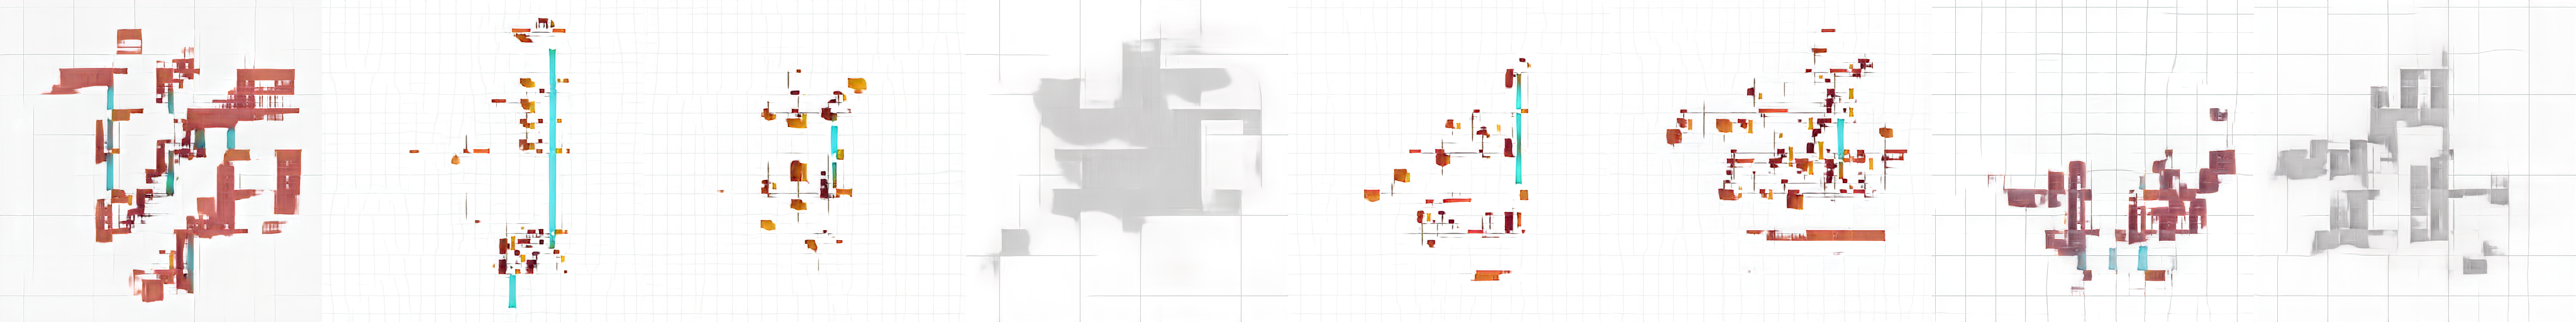

In [83]:
# Generate a series of images

set_truncation(0.7)
seeds = [0,1,2,3,4,5,6,7]

collage = PIL.Image.new('RGB', (len(seeds)*resolution, resolution))

for x_step, seed in enumerate(seeds):
  img = generate(*get_seed(seed))
  collage.paste(img, (x_step*resolution,0))

collage.save(os.path.join(output_path,'seeds_%s_%.2f.png' % (str(seeds),truncation())))

collage

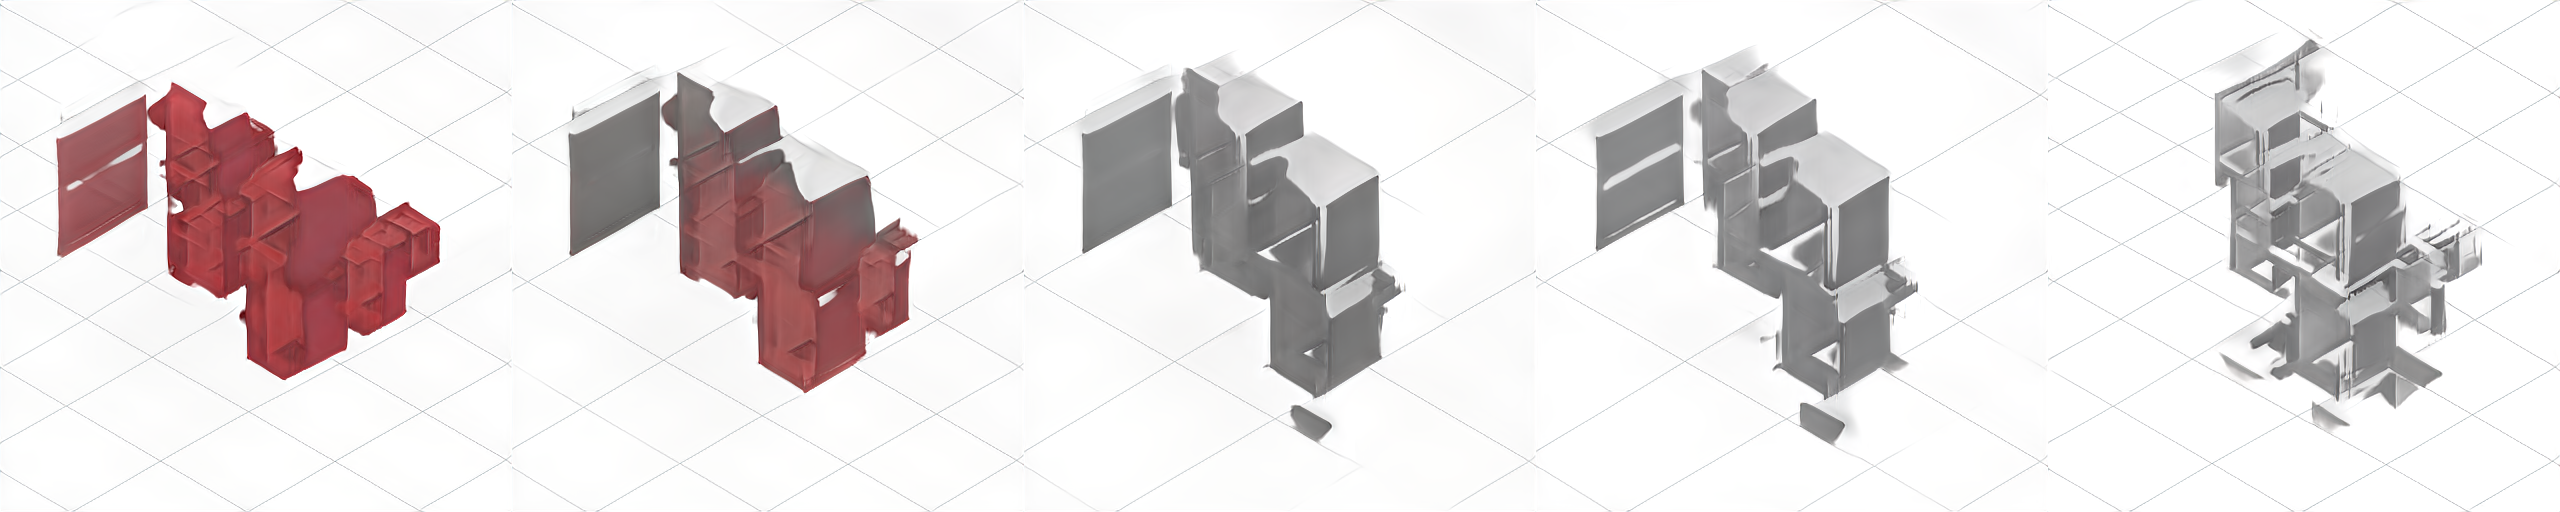

In [91]:
# Generate a one-dimensional interpolation

steps = 5
seed_a = 10
seed_b = 12

collage = PIL.Image.new('RGB', (steps*resolution, resolution))

for step in range(steps):
  img = generate(*mix_seeds(seed_a, seed_b, step/steps))
  collage.paste(img, (step*resolution,0))

collage.save(os.path.join(output_path,'interpolation_%i_%i_%i_%.2f.png' % (steps,seed_a,seed_b,truncation())))

collage

In [92]:
# Generate a two-dimensional interpolation between four seeds

set_truncation(1.0)
seeds = [10,12,33,71]
collage_size = (5, 5)

x_steps, y_steps = collage_size[0], collage_size[1]
collage = PIL.Image.new('RGB', (x_steps*resolution, y_steps*resolution))
top_row = [mix_seeds(seeds[0], seeds[1], step/x_steps) for step in range(x_steps)]
bottom_row = [mix_seeds(seeds[2], seeds[3], step/x_steps) for step in range(x_steps)]

for x_step in range(x_steps):
  for y_step in range(y_steps):
    img = generate(*mix_latents(top_row[x_step], bottom_row[x_step], y_step/y_steps))
    collage.paste(img, (x_step*resolution,y_step*resolution))

collage.save(os.path.join(output_path,'2d_interpolation_%ix%i_%i_%i_%i_%i_%.2f.png' % (x_steps,y_steps,*seeds,truncation())))

collage

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Generate a two-dimensional map from a list of seeds

set_truncation(0.7)
seeds = [0,1, 2, 3]
# list of seeds [n1,n2,n3,n4] or range(n1, n2)

x_size = math.ceil(math.sqrt(len(seeds)))
y_size = math.ceil(len(seeds)/x_size)
collage = PIL.Image.new('RGB', (x_size*resolution, y_size*resolution))
for i, seed in enumerate(seeds):
  x_step = i%x_size
  y_step = i//x_size
  img = generate(*get_seed(seed))
  collage.paste(img, (x_step*resolution,y_step*resolution))

collage.save(os.path.join(output_path,'map_%.2f_seeds_%s.png' % (truncation(), str(seeds))))

collage

In [ ]:
# Generate an interpolation video

set_truncation(0.7)
seeds = range(100,120)
frames_per_seed = 10
frame_rate = 30

tmp_dir = '/content/frames'
!mkdir -p $tmp_dir
!rm -rf /content/frames/*.png
frame = 0
for i in range(len(seeds)):
  print(seeds[i], end=' ')
  for step in range(frames_per_seed):
    frame = i * frames_per_seed + step
    zi, ni = mix_seeds(seeds[i], seeds[(i+1)%len(seeds)], step/frames_per_seed)
    img = generate(zi,ni)
    img.save(os.path.join(tmp_dir, 'frame%05d.png' % frame))
mp4_name = '"' + os.path.join(output_path, 'interpolations_%i_%i_%i_steps_trunc_%.2f.mp4' % (seeds[0], seeds[-1], frames_per_seed, truncation())) + '"'
!ffmpeg -framerate {frame_rate} -f image2 -pattern_type glob -i '/content/frames/frame*.png' -y -vcodec libx264 $mp4_name
